In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

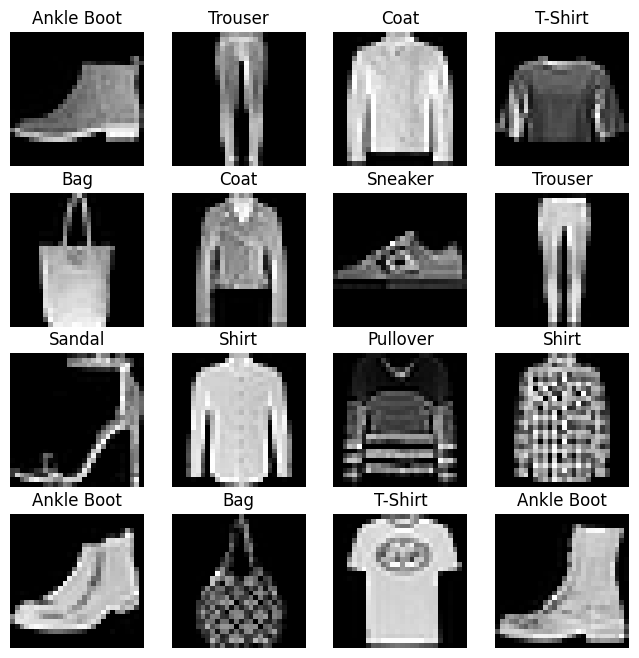

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
data_count = len(training_data.data)
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(data_count, size=(1,)).item())
    plt.subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(training_data.data[sample_idx], cmap="gray")
    plt.title(label=labels_map[int(training_data.targets[sample_idx].item())])
plt.show()

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


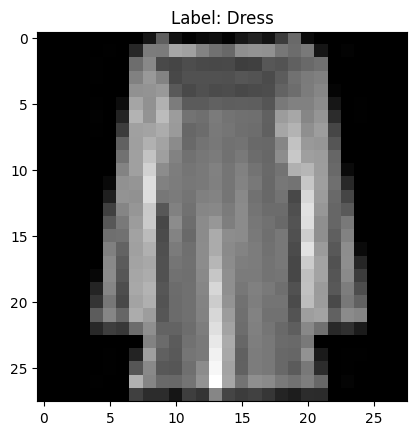

In [5]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature shape: {train_features.shape}")
print(f"Labels shape: {train_labels.shape}")

img = train_features[0].squeeze()
label = train_labels[0].item()
plt.imshow(img, cmap="gray")
plt.title(f"Label: {labels_map[label]}")
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)

        self.dropout1 = nn.Dropout()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout1(self.conv2(x)), 2)).view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = CNN()

In [7]:
# model = NeuralNetwork()

In [8]:
model.eval()
with torch.inference_mode():
    predictions = model(train_features)
    print(predictions[0], labels_map[int(predictions[0].argmax(dim=0))])

tensor([-2.2299, -2.3338, -2.2877, -2.3902, -2.1466, -2.2453, -2.4146, -2.2885,
        -2.3981, -2.3234]) Coat


In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X, y

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [12]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.035911 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 15.3%, Avg loss: 0.035204 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.031987 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.020889 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.1%, Avg loss: 0.015824 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.014234 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.013308 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 69.4%, Avg loss: 0.012838 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.012394 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.012326 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 72.5%, Avg los

In [13]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
error = 0
test = 1000
for i in range(test):
    index = int(torch.randint(len(test_data), size=(1,)).item())
    model.eval()
    x, y = test_data[index][0], test_data[index][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        if predicted != actual:
            error += 1
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
print(f"Accuracy: {(100*(test-error)/test):>0.1f}%")

Predicted: "Coat", Actual: "Coat"
Predicted: "Coat", Actual: "Pullover"
Predicted: "Bag", Actual: "Bag"
Predicted: "Sandal", Actual: "Sandal"
Predicted: "Trouser", Actual: "T-shirt/top"
Predicted: "T-shirt/top", Actual: "Dress"
Predicted: "Pullover", Actual: "Coat"
Predicted: "T-shirt/top", Actual: "T-shirt/top"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "T-shirt/top", Actual: "Dress"
Predicted: "Coat", Actual: "Coat"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "T-shirt/top", Actual: "T-shirt/top"
Predicted: "Dress", Actual: "Bag"
Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Coat", Actual: "Shirt"
Predicted: "Sneaker", Actual: "Sneaker"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Shirt", Actual: "Pullover"
Predicted: "Dress", Actual: "Dress"
Predicted: "Sandal", Actual: "Sandal"
Predicte